# ImageNet-ONNX Runtime部署-摄像头和视频-中文

使用 ImageNet 预训练图像分类模型，预测摄像头实时画面。

本代码需在`连接摄像头的本地`运行，不能在云GPU平台运行。

同济子豪兄：https://space.bilibili.com/1900783

测试运行环境：Macbook Pro

## 导入工具包

In [2]:
import os

import cv2
from cvs import *
import numpy as np
import pandas as pd

from tqdm import tqdm # 进度条

import torch
import torch.nn.functional as F
from torchvision import transforms

import onnxruntime

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

## 导入中文字体

In [3]:
# 导入中文字体，指定字体大小
font = ImageFont.truetype('SimHei.ttf', 32)

## 载入 onnx 模型

In [4]:
ort_session = onnxruntime.InferenceSession('resnet18_imagenet.onnx')

## 载入ImageNet 1000图像分类标签

ImageNet 1000类别中文释义：https://github.com/ningbonb/imagenet_classes_chinese

In [5]:
# 载入ImageNet 1000图像分类标签
df = pd.read_csv('imagenet_class_index.csv')
idx_to_labels = {}
for idx, row in df.iterrows():
    idx_to_labels[row['ID']] = row['Chinese']

In [6]:
# idx_to_labels

## 图像预处理

In [7]:
# 测试集图像预处理-RCTN：缩放裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 初始化摄像头

In [8]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [9]:
cap = cvs.VideoCapture(Camera_ID)

('app runs on port:', 37946)
open the cam:0 ...


remi.server      INFO     Started httpserver http://0.0.0.0:37946/
remi.request     INFO     built UI (path=/)
remi.server.ws   INFO     connection established: ('192.168.1.2', 51402)
remi.server.ws   INFO     handshake complete
remi.server.ws   INFO     connection established: ('127.0.0.1', 42238)
remi.server.ws   INFO     handshake complete
remi.server.ws   ERROR    Error managing incoming websocket message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 175, in read_next_message
    self.on_message(from_websocket(decoded))
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 245, in on_message
    self.send_message(_MSG_ACK)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_message
    self.request.sendall(out)
BrokenPipeError: [Errno 32] Broken pipe
remi.server.ws   INFO     connection established: ('127.0.0.1', 42272)
remi.server.ws   INFO     handshake complete


## 调用摄像头获取一帧画面，预测

### 拍摄一帧画面

In [15]:
img_bgr = cap.read()

In [16]:
img_bgr.shape

(640, 480, 3)

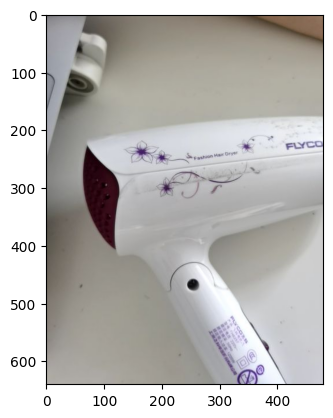

In [17]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

### 画面转成 RGB 的 Pillow 格式

In [18]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB

In [19]:
img_pil = Image.fromarray(img_rgb)

In [20]:
# img_pil

### 预处理

In [21]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

### ONNX Runtime推理预测

In [22]:
# onnx runtime 输入
ort_inputs = {'input': input_tensor}

# onnx runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

### 获得预测结果

In [23]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [24]:
pred_softmax.shape

torch.Size([1, 1000])

### 解析top-n预测结果的类别和置信度

In [25]:
## 解析图像分类预测结果
n = 3
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度

### 在图像上写中文

In [26]:
draw = ImageDraw.Draw(img_pil) 

for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    
    # 写中文：文字坐标，中文字符串，字体，rgba颜色
    text = '{:<12} {:>.2f}'.format(pred_class, confs[i]) # 中文字符串
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    
img_rgb = np.array(img_pil) # PIL 转 array

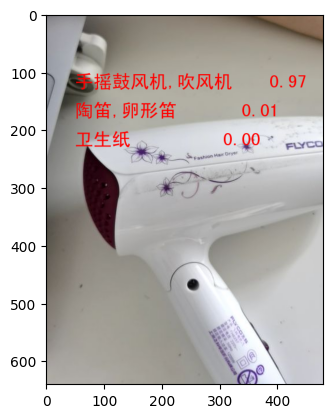

In [27]:
plt.imshow(img_rgb)
plt.show()

## 处理单帧画面的函数（中文）

In [28]:
# 处理帧函数
def process_frame(img_bgr):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL

    ## 预处理
    input_img = test_transform(img_pil) # 预处理
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ## onnx runtime 预测
    ort_inputs = {'input': input_tensor} # onnx runtime 输入
    pred_logits = ort_session.run(['output'], ort_inputs)[0] # onnx runtime 输出
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
    
    ## 解析图像分类预测结果
    n = 3
    top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
    confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度
    
    
    ## 在图像上写中文
    draw = ImageDraw.Draw(img_pil) 
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        
        # 写中文：文字坐标，中文字符串，字体，rgba颜色
        text = '{:<12}{:.2f}'.format(pred_class, confs[i]) # 中文字符串
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
        
    img_rgb = np.array(img_pil) # PIL 转 array
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR) # RGB转BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)  
    # 图片，添加的文字，左上角坐标，字体，字体大小，颜色，线宽，线型
    img_bgr = cv2.putText(img_bgr, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
    return img_bgr

## 预测摄像头单帧画面

In [35]:
img_bgr = cap.read()

In [36]:
img_bgr = process_frame(img_bgr)

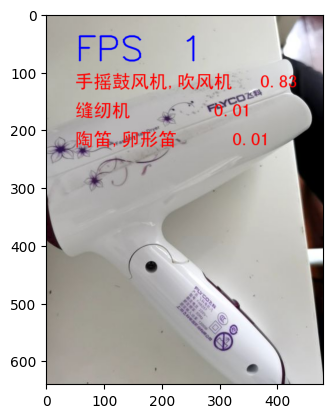

In [37]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 逐帧实时处理手机摄像头拍摄的画面-代码模板

In [ ]:
while True:
    img_bgr = cap.read()
    
    if img_bgr is None:
        continue
        
    img_bgr = process_frame(img_bgr)
    
    cvs.imshow(img_bgr)

> 点击`重启kernel`关闭摄像头

## 视频逐帧处理（模板）

In [75]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [76]:
generate_video(input_path='video_4.mp4')

ERROR! Session/line number was not unique in database. History logging moved to new session 111
视频开始处理 video_4.mp4
视频总帧数为 283


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [02:12<00:00,  2.13it/s]

视频已保存 out-video_4.mp4



remi.server.ws   ERROR    Error managing incoming websocket message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 166, in read_next_message
    length = self.bytetonum(length[1]) & 127
IndexError: index out of range
remi.request     ERROR    sending websocket spontaneous message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 497, in _send_spontaneous_websocket_message
    if ws.send_message(message):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_message
    self.request.sendall(out)
BrokenPipeError: [Errno 32] Broken pipe
